In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer,TextIteratorStreamer
from transformers.models.qwen2.modeling_qwen2 import Qwen2Attention,Qwen2Config,apply_rotary_pos_emb
import torch
from typing import Callable, List, Optional, Tuple, Union,Unpack
from transformers.cache_utils import Cache, DynamicCache, StaticCache
from transformers.modeling_flash_attention_utils import FlashAttentionKwargs

import inspectus
from typing import Optional, Tuple
import torch.nn as nn
import torch
import os


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


def sdpa_attention_forward(
    module: torch.nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    dropout: float = 0.0,
    scaling: Optional[float] = None,
    is_causal: Optional[bool] = None,
    **kwargs,
) -> Tuple[torch.Tensor, None]:
    if hasattr(module, "num_key_value_groups"):
        key = repeat_kv(key, module.num_key_value_groups)
        value = repeat_kv(value, module.num_key_value_groups)

    causal_mask = attention_mask
    if attention_mask is not None:
        causal_mask = causal_mask[:, :, :, : key.shape[-2]]

    # SDPA with memory-efficient backend is bugged with non-contiguous inputs and custom attn_mask for some torch versions
    # Reference: https://github.com/pytorch/pytorch/issues/112577.
    query = query.contiguous()
    key = key.contiguous()
    value = value.contiguous()

    # We dispatch to SDPA's Flash Attention or Efficient kernels via this `is_causal` if statement instead of an inline conditional assignment
    # in SDPA to support both torch.compile's dynamic shapes and full graph options. An inline conditional prevents dynamic shapes from compiling.
    if is_causal is None:
        is_causal = causal_mask is None and query.shape[2] > 1
    attn_weights = query @ key.transpose(-2, -1)
    attn_output = torch.nn.functional.scaled_dot_product_attention(
        query,
        key,
        value,
        attn_mask=causal_mask,
        dropout_p=dropout,
        scale=scaling,
        is_causal=is_causal,
    )
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights


class CustomQwen2Attention(nn.Module):
    def __init__(self, atten:Qwen2Attention):
        super().__init__()
        self.config = atten.config
        self.layer_idx = atten.layer_idx
        self.head_dim = getattr(self.config, "head_dim", self.config.hidden_size // self.config.num_attention_heads)
        self.num_key_value_groups = self.config.num_attention_heads // self.config.num_key_value_heads
        self.scaling = self.head_dim**-0.5
        self.attention_dropout = self.config.attention_dropout
        self.is_causal = True
        self.q_proj = atten.q_proj
        self.k_proj = atten.k_proj
        self.v_proj = atten.v_proj
        self.o_proj = atten.o_proj
    
    def forward(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: Tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_value: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs: Unpack[FlashAttentionKwargs],
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_value is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

        sliding_window = None
        if (
            self.config.use_sliding_window
            and getattr(self.config, "sliding_window", None) is not None
            and self.layer_idx >= self.config.max_window_layers
        ):
            sliding_window = self.config.sliding_window

        attn_output, attn_weights = sdpa_attention_forward(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            sliding_window=sliding_window,  # main diff with Llama
            **kwargs,
        )
        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)
        return attn_output, attn_weights
    
def vis_kv(model,tokenizer,query,past_key_values=None):

    model_inputs = tokenizer(query, return_tensors="pt").to("cuda")
    generate_kwargs = {
            'max_new_tokens': 1,
            'past_key_values': past_key_values,
            'pad_token_id': tokenizer.eos_token_id,
            'top_p': 0.95,
            'temperature': 0.1,
            'repetition_penalty': 1.0,
            'top_k': 50,
            "return_dict_in_generate":True,
            "output_attentions":True,
        }
    if past_key_values is not None:
        past_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        cache_position = torch.arange(
            past_length if past_length == model_inputs.input_ids.shape[1] else past_length, model_inputs.input_ids.shape[1], device=model_inputs.input_ids.device
        )
        generate_kwargs['cache_position'] = cache_position
    
    
    outputs = model.generate(**model_inputs, **generate_kwargs)
    past_key_values = outputs.past_key_values
    generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, outputs.sequences)
        ]
    atten = outputs.attentions
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return response,model_inputs.input_ids,past_key_values,atten


/root/miniconda3/envs/vllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def vis_atten(tokens,attens):
    # query = "Hello, How are you?"
    # response1,input_ids1,past_key_values1,atten1 = vis_kv(model,tokenizer,query)
    # tokens= input_ids1.tolist()[0]
    attens = [i for i in attens[0]]
    attens = torch.cat(attens,dim=0)

    inspectus.attention(attens.cpu().to(torch.float32).numpy(), tokens, 
        chart_types=['attention_matrix', 'query_token_heatmap', 'key_token_heatmap', 'dimension_heatmap', 'token_dim_heatmap', 'line_grid']
            ,color={
                'query_token_heatmap': 'orange',
                'key_token_heatmap': 'green',
                'token_dim_heatmap': 'red',
            }
        )

In [81]:
model_name = "Qwen/Qwen2.5-7B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_name,device_map="cuda",torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name,device_map="cuda",torch_dtype=torch.bfloat16)

# for layer in model.model.layers:
#     layer.self_attn = CustomQwen2Attention(layer.self_attn)


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
/root/miniconda3/envs/vllm/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
/root/miniconda3/envs/vllm/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26368 (\N{CJK UNIFI

28
tensor([0.9632], grad_fn=<SumBackward1>)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
/tmp/ipykernel_1248292/673414537.py:55: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from font(s) DejaVu Sans.
  plt.savefig("attens.png")
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
/tmp/ipykernel_1248292/673414537.py:55: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.savefig("attens.png")
/tmp/ipykernel_1248292/673414537.py:55: UserWarning: Glyph 22909 (\N{CJK UNIFIED IDEOGRAPH-597D}) mi

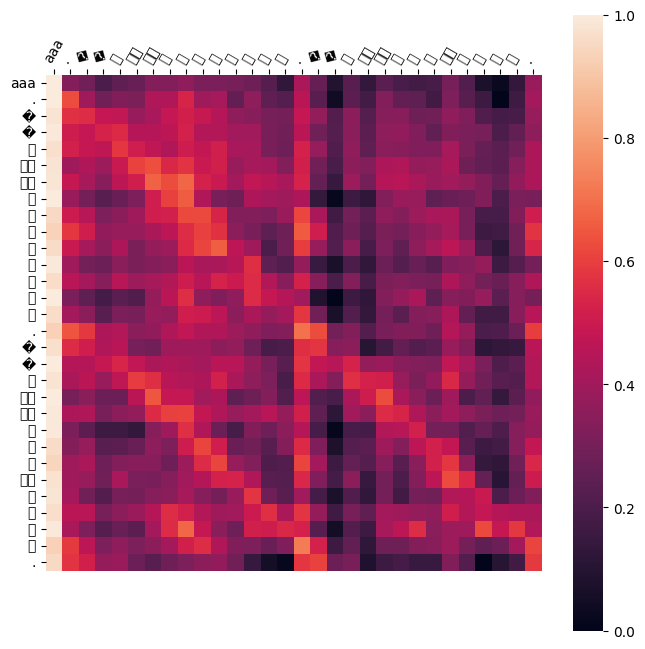

In [79]:
def min_max_normalization(matrix):
    min_val = torch.min(matrix)
    max_val = torch.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

query1 = "I come from China, I am a teacher. "
response2,input_ids2,past_key_values1,atten1 = vis_kv(model,tokenizer,query1,None)

# query2 = "I am a student. I come from USA."
# query2 = "Bananas are a kind of delicious fruit. Apples are a kind of delicious fruit."
query2 = "aaa. 北京最好吃的烤鸭店是大董烤鸭. 北京最好吃的烤鸭店不是大董烤鸭."
response2,input_ids2,past_key_values2,atten2 = vis_kv(model,tokenizer,query2,None)
tokens_embeddings = model.model.embed_tokens(input_ids2).cpu().to(torch.float32)
tokens= input_ids2.tolist()[0]
tokens = [tokenizer.decode([i]).strip() for i in tokens]

target = [".", "?"]
indices = [i for i, x in enumerate(tokens) if x in target]

from sentence_transformers import SentenceTransformer, util
print(len(atten2[0]))
attens = atten2[0][-2].cpu().to(torch.float32)
attens = attens.squeeze(0).mean(dim=0)
# attens = min_max_normalization(attens)
sentence_embedding = []
last_index = 0
for i in indices:
    attens[last_index:i+1,:] =  min_max_normalization(attens[last_index:i+1,:])
    weights = attens[last_index:i+1,last_index:i+1].max(dim=0).values.unsqueeze(0)
    # sentence_embedding.append(torch.matmul(weights,tokens_embeddings[0,last_index:i+1,:]))
    sentence_embedding.append(torch.mean(tokens_embeddings[:,last_index:i+1,:],dim=1))
    last_index = i+1
if last_index < len(tokens):
    attens[last_index:,:] =  min_max_normalization(attens[last_index:,:])

# 计算余弦相似度
cosine_similarity = torch.nn.functional.cosine_similarity(sentence_embedding[1], sentence_embedding[2])
print(cosine_similarity)
# print(attens.shape)
from matplotlib import pyplot as plt
import seaborn
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=True, ax=ax)
        # 将 x 轴的刻度和标签移到顶部
    ax.xaxis.tick_top()
    # 将 x 轴的标签位置设置到顶部
    ax.xaxis.set_label_position('top')
    plt.setp(ax.get_xticklabels(), rotation=60, ha="left", rotation_mode="anchor")
fig, axs = plt.subplots(1,1, figsize=(8, 8))#布置画板

draw(attens,x=tokens,y= tokens, ax=axs)
# 这里保存的图片是空白的
plt.savefig("attens.png")

plt.show()


In [84]:
# from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer, util
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
q1 = "Apple is good fruit for health"
q2 = "Banana is good fruit for person"
query_embedding = sentence_model.encode(q1)
passage_embedding = sentence_model.encode(q2)

print(util.dot_score([query_embedding], [passage_embedding]))


response,input_ids1,past_key_values,atten1 = vis_kv(model,tokenizer,q1)
response,input_ids2,past_key_values,atten2 = vis_kv(model,tokenizer,q2)

embeddings1 = model.get_input_embeddings()(input_ids1).cpu().to(torch.float32)
embeddings2 = model.get_input_embeddings()(input_ids2).cpu().to(torch.float32)


pool_embeddings1 = torch.mean(embeddings1,dim=1)
pool_embeddings2 = torch.mean(embeddings2,dim=1)

print( torch.nn.functional.cosine_similarity(pool_embeddings1,pool_embeddings2))





tensor([[0.6576]])
tensor([0.7209], grad_fn=<SumBackward1>)
